***Total: 42 points***

Complete this homework by writing R code to complete the following tasks. Keep in mind:

i. Empty chunks have been included where code is required
ii. For Problem 2e, you should include a image (screen shot), which can be loaded into R
iii. This homework requires use of data files:

  - `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg` (Problems 1, 2)
  - `GIAB_highconf_v.3.3.2.vcf.gz` (Problem 3)
  
iv. You will be graded on your code and output results (knitted .html file). The assignment is worth 42 points total; partial credit can be awarded.

This assignment is due on **Dec 1, 2022**. 

For additional resources, please refer to these links:  
Problems 1 & 2:  
  - https://www.bioconductor.org/packages/devel/bioc/vignettes/plyranges/inst/doc/an-introduction.html
  - https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html  
Problem 3:  
  - https://bioconductor.org/packages/release/bioc/vignettes/Rsamtools/inst/doc/Rsamtools-Overview.pdf  
Problem 4: 
  - https://bioconductor.org/packages/release/bioc/vignettes/VariantAnnotation/inst/doc/VariantAnnotation.pdf  

# Problem 1: Overlaps between genomic regions and copy number alterations. (14 points total)

### Preparation
Load copy number segment results as shown in *2.1 BED format* of *Lecture16_GenomicData.Rmd*. You will use the same file as in the lecture notes, `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg`. Here is code to get you started.

In [2]:
#This homework was completed using Lecture 15 code.
#load necessary packages including png and tidyverse
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(plyranges)
    library(VariantAnnotation)
    library(tidyverse)
    library(png)
})

In [3]:
#change working directory
data_dir = '/workspaces/tfcb_2022/homeworks/homework07/data' #copy file path of BRCA.genome_wide file here
setwd(data_dir)

In [ ]:
list.files() #check list to confirm file is available

In [5]:
segs <- read.delim("BRCA.genome_wide_snp_6_broad_Level_3_scna.seg", as.is = TRUE) #read in segs file 
mode(segs$Chromosome) <- "character" #change chromosome data type to character
segs[segs$Chromosome == 23, "Chromosome"] <- "X" #replace Chr 23 with X
segs.gr <- as(segs, "GRanges") #covert to GRanges file

### a. Find the segments in `segs.gr` that have *any* overlap with the region `chr8:128,746,347-128,755,810` (4 points)
Print out the first five unique TCGA IDs.

In [6]:
#make new GRanges of interest
grange1<- GRanges(seqnames = "8", ranges = IRanges(start = 128746347, end = 128755810))

#find overlap with segs.gr and convert to dataframe
segs.overlap<- data.frame(find_overlaps(segs.gr, grange1))

#print first 5 TCGA IDs
segs.overlap[1:5,'Sample']


[1] "TCGA-3C-AAAU-10A-01D-A41E-01" "TCGA-3C-AAAU-01A-11D-A41E-01"
[3] "TCGA-3C-AALI-10A-01D-A41E-01" "TCGA-3C-AALI-01A-11D-A41E-01"
[5] "TCGA-3C-AALJ-10A-01D-A41E-01"

### b. Find the mean of the `Segment_Mean` values for copy number segments that have *any* overlap with the region chr17:37,842,337-37,886,915. (4 points)

In [7]:
#new GRange of interest
grange2<- GRanges(seqnames='17', ranges = IRanges(start=37842337, end = 37886916))

#find overlap with segs.gr and convert to dataframe
segs.overlap2<-data.frame(find_overlaps(segs.gr, grange2))

#find mean of Segment_Mean values
mean(segs.overlap2$Segment_Mean)

[1] 0.1420197

### c. Find the patient sample distribution of copy number for `PIK3CA` (hg19). (6 points)
Find the counts of samples with deletion (D; `Segment_Mean < -0.3`), neutral (N; `Segment_Mean >= -0.3 & Segment_Mean <= 0.3`), gain (G; `Segment_Mean > 0.3`) segments that have `any` overlap with `PIK3CA` gene coordinates.  


In [8]:
#new GRange with PIK3CA coordinates
grangep<- GRanges(seqnames='3', ranges=IRanges(start=179148126, end=179240093)) #gene location from OMIM.org

#find overlap with segs.gr and convert to dataframe 
segs.overlapp<-data.frame(find_overlaps(segs.gr, grangep))

#find number of deletions
del<- segs.overlapp %>%
  filter(Segment_Mean < -0.3)
nrow(del)

#find number of neutral reads
neut<- segs.overlapp %>%
  filter(Segment_Mean >= -0.3 & Segment_Mean <= 0.3)
nrow(neut)

#find number of gains
gain<- segs.overlapp %>%
  filter(Segment_Mean > 0.3)
nrow(gain)

[1] 14

[1] 2024

[1] 165

# Problem 2: Frequency of copy number alteration events within genomic regions. (12 points total) 

This problem will continue to use the copy number data stored in `segs.gr`.

### a. Create a genome-wide tile of 1Mb windows for the human genome (`hg19`). (4 points)
See *3.1 Tiling the genome* of *Lecture16_GenomicData.Rmd* for hints.


In [ ]:
#read in reference genome
seqinfo <- Seqinfo(genome = "hg19")
#edit style to keep standard chromosomes and use NCBI system
seqinfo <- keepStandardChromosomes(seqinfo) 
seqlevelsStyle(seqinfo) <- "NCBI"
#find length of chromosomes
slen <- seqlengths(seqinfo)
#set title widths
tileWidth <- 1000000
#break reference genome into tiles
tiles <- tileGenome(seqlengths = slen, tilewidth = tileWidth, cut.last.tile.in.chrom = TRUE)

### b. Find the 1Mb window with the most frequent overlapping deletions. (4 points)
Find the 1Mb windows with `any` overlap with deletion copy number segments. Assume a deletion segment is defined as a segment in `segs.gr` having `Segment_Mean < -0.3`. 

Return one of the 1Mb window `Granges` entry with the highest frequency (count) of deletion segments.

Hint: Subset the `segs.gr` to only rows with `Segment_Mean < -0.3`. 

In [10]:
#subset segs.gr to only deletions
segs.grdel<- segs.gr %>%
  filter(Segment_Mean < -0.3)

#find overlap with 1MB tiles of reference genome
overlapdel<- data.frame(find_overlaps(segs.grdel, tiles))

#return tile with greatest number of deletion segments
maxdel<-as.integer(tail(names(sort(table(overlapdel$seqnames))), 1))
print(tiles[maxdel])

GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]        1 10000001-11000000      *
  -------
  seqinfo: 25 sequences from an unspecified genome


### c. Visually inspect the deletion overlap result from part (b) using IGV. (4 points)
Provide a screen shot of IGV at the 1Mb window with the most frequent overlap with deletion segments. The image should include the segments from `BRCA.genome_wide_snp_6_broad_Level_3_scna.seg` loaded. 

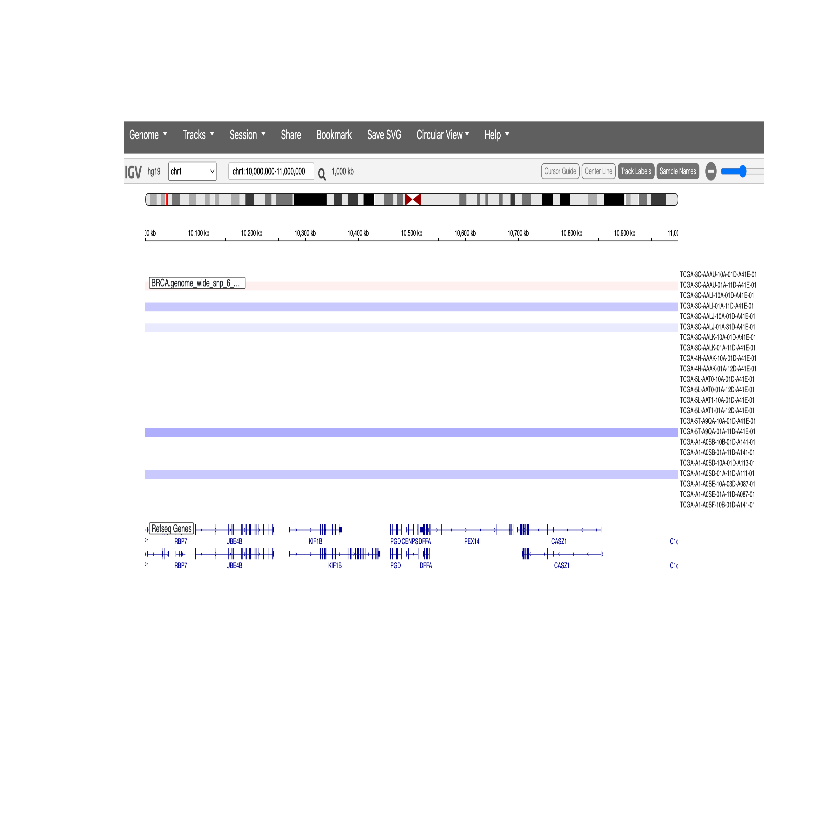

In [27]:
#load in screenshot from igv
pp <- readPNG('igv.png')
plot.new() 
rasterImage(pp,0,0,1,1)


# Problem 3: Reading and annotating genomic variants (16 points total)


### a. Load variant data from VCF file `GIAB_highconf_v.3.3.2.vcf.gz` for `chr8:128,700,000-129,000,000`. (4 points)
Note: use genome build `hg19`.

In [41]:
#set up VCF parameters as desired
vcfFile <- "GIAB_highconf_v.3.3.2.vcf.gz"
vcfHead <- scanVcfHeader(vcfFile)
myGRangevcf <- GRanges(seqnames = "8", ranges = IRanges(start = 128700000, end = 129000000))
vcf.param <- ScanVcfParam(which = myGRangevcf) 

In [43]:
#read VCF file in reference to hg19
vcf <- readVcf(vcfFile, genome = "hg19", param = vcf.param)

### b. Combine the fields of the VCF genotype information into a table. (4 points)
You may use your choice of data objects (e.g. `data.frame`).

In [70]:
#load VCF into dataframe with column names from VCF header
genoData <- data.frame(do.call(cbind, geno(vcf)))
colnames(genoData) <- rownames(geno(header(vcf)))

genoData

,GT,DP,GQ,ADALL,AD,IGT,IPS,PS
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>
rs6984323,1|1,765,583,"1, 332","0, 315",1/1,.,PATMAT
rs4478537,0|1,544,813,"103, 124","135, 172",0/1,.,PATMAT
rs34141920,0|1,523,222,"132, 121","132, 121",0/1,.,PATMAT
rs17772814,1|0,695,1503,"143, 158","196, 199",0/1,.,PATMAT
rs77977256,1|0,642,685,"154, 157","160, 166",0/1,.,PATMAT
8:128715845_AT/A,0|1,368,99,"66, 91","66, 91",0/1,.,PATMAT
rs143209301,1|0,581,595,"128, 128","151, 165",0/1,.,PATMAT
rs202231913,0|1,369,99,"81, 97","81, 97",0/1,.,PATMAT
rs16902340,0|1,689,1294,"144, 150","184, 204",0/1,.,PATMAT


### c. Retrieve the following information at chr8:128747953. (8 points)
Print out the SNP ID (i.e. "rs ID"), reference base (`REF`), alterate base (`ALT`), genotype (`GT`), depth (`DP`), allele depth (`ADALL`), phase set (`PS`).

Hints: 

  i. `REF` and `ALT` are in the output of `rowRanges(vcf)`. See Section `3a` in `Lecture16_VariantCalls.ipynb` 
  ii. To get the sequence of `DNAString`, use `as.character(x)`.  
  ii. To get the sequence of `DNAStringSet`, use `as.character(unlist(x))`. 
  iii. To expand a list of information for `geno`, use `unlist(x)`.  

  

In [82]:
#new GRange of interest
mygrangevcf<- GRanges(seqnames='8', ranges=IRanges(start=128747953, end=128747953))
#set GRange as new parameter
newparam<- ScanVcfParam(which=mygrangevcf)
newvcf <- readVcf(vcfFile, genome = "hg19", param = newparam)
newgenoData <- data.frame(do.call(cbind, geno(newvcf)))
colnames(genoData) <- rownames(geno(header(newvcf)))
#retrieve desired information
unlist(geno(newvcf))
rowRanges(newvcf)


HG001   
GT.rs3824120    0|1     
DP.rs3824120    461     
GQ.rs3824120    668     
ADALL.rs3824120 105, 94 
AD.rs3824120    128, 121
IGT.rs3824120   0/1     
IPS.rs3824120   .       
PS.rs3824120    PATMAT

GRanges object with 1 range and 5 metadata columns:
            seqnames    ranges strand | paramRangeID            REF
               <Rle> <IRanges>  <Rle> |     <factor> <DNAStringSet>
  rs3824120        8 128747953      * |           NA              G
                           ALT      QUAL      FILTER
            <DNAStringSetList> <numeric> <character>
  rs3824120                  T        50        PASS
  -------
  seqinfo: 25 sequences from hg19 genome